In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import cv2

Identifying Region of Interest (ROI)

(768, 1024, 3)

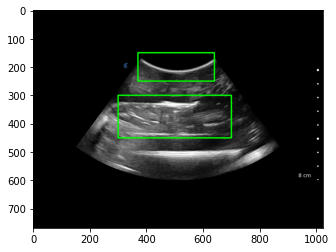

In [64]:
image_path = 'C:/Users/abhip/Desktop/School/MQP/Ultrasound_Needle_Insertion_Software_MQP/Data/probe_impedence_V2/capture_2_2022-11-19T16-35-59.jpeg'
groundTruth_path = 'C:/Users/abhip/Desktop/School/MQP/Ultrasound_Needle_Insertion_Software_MQP/Data/ground_truth.jpeg'
#test image
test_image = cv2.imread(image_path)

#ground truth image
ground_truth = cv2.imread(groundTruth_path) #using the pure water sample as he ground truth value

#bounding region of metal object
x1,x2 = (300,300),(700,450) #top left corner is x1, bottom right corner is x2

#bounding region of probe head section
y1,y2 = (370,150), (640,250) #top left corner is y1, bottom right corner is y2

cv2.rectangle(test_image,x1,x2,(0,255,0),3)
cv2.rectangle(test_image,y1,y2,(0,255,0),3)
plt.imshow(test_image)
test_image.shape


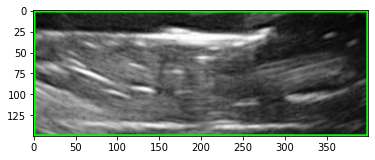

In [36]:
roi_object = test_image[300:450, 300:700]
plt.imshow(roi_object)

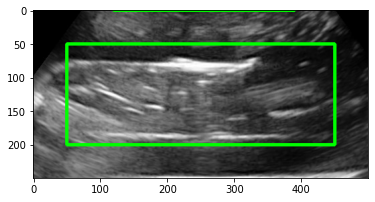

In [44]:
surrounding_tissue = test_image[250:500, 250:750] #surrounding tissue region (slightly expanded version of ROI)
plt.imshow(surrounding_tissue)

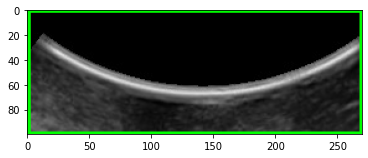

In [39]:
roi_top = test_image[150:250, 370:640,]
plt.imshow(roi_top)

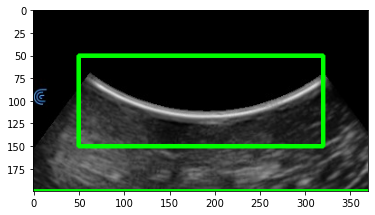

In [138]:
surrounding_tissue = test_image[(150-50):(250+50), (370-50):(640+50)]
plt.imshow(surrounding_tissue)

Calculating CNR

In [46]:
#CNR VERSION 1

def calculate_cnr(images, object1, object2):
  # Calculate the difference in intensity between the two objects
  intensity_diff = np.abs(np.mean(object1) - np.mean(object2))

  # Calculate the standard deviation of the noise in the images
  noise_std = np.std(images)

  # Calculate the CNR by dividing the intensity difference by the noise standard deviation
  cnr = intensity_diff / noise_std

  return cnr

calculate_cnr(test_image, roi_object,surrounding_tissue)

0.30157203660631116

In [51]:
#CNR VERSION 2

# Apply filters and thresholding to enhance the contrast in the region of interest
filtered_img = cv2.medianBlur(test_image, 3)
# plt.imshow(filtered_img)
# thresholded_img = cv2.threshold(filtered_img, 100, 255, cv2.THRESH_BINARY)
# plt.imshow(thresholded_img)
# thresholded_img
# # Measure the intensity of the signal in the region of interest
roi_object = filtered_img[300:450, 300:700]

# Measure the intensity of the signal in the region of interest
roi_mean = np.mean(roi_object)

# Measure the intensity of the signal in the surrounding tissue
surrounding_tissue = filtered_img[250:500, 250:750]
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:450], axis=0)
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:700], axis=1)
surrounding_mean = np.mean(surrounding_tissue)

# Calculate the contrast and the noise level
contrast = roi_mean - surrounding_mean
noise = np.std(surrounding_tissue)

# Calculate the CNR
cnr = contrast / noise
cnr

-0.03791121413722566

In [57]:
#CNR VERSION 3
from scipy.stats import norm

# Divide the image into the region of interest and the surrounding tissue
roi = test_image[300:450, 300:700]
surrounding_tissue = test_image[250:500, 250:750]

#remove the region of interest from the surrounding_tissue array
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:450], axis=0)
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:700], axis=1)

# Fit a Gaussian distribution to the intensity values in each region
roi_dist = norm.fit(roi)
surrounding_dist = norm.fit(surrounding_tissue)

# Calculate the peak values of the distributions
roi_peak = roi_dist[0]
surrounding_peak = surrounding_dist[0]

# Calculate the standard deviation of the surrounding tissue
surrounding_std = surrounding_dist[1]

# Calculate the CNR
cnr = (roi_peak - surrounding_peak) / surrounding_std
cnr

-0.037458524813745356

In [58]:
#CNR VERSION 4

# Measure the intensity of the signal in the region of interest
roi_object = test_image[300:450, 300:700]

# Measure the intensity of the signal in the region of interest
roi_mean = np.mean(roi_object)

# Measure the intensity of the signal in the surrounding tissue
surrounding_tissue = test_image[250:500, 250:750]
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:450], axis=0)
surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:700], axis=1)
surrounding_mean = np.mean(surrounding_tissue)

# Calculate the contrast and the noise level
contrast = roi_mean - surrounding_mean
noise = np.std(surrounding_tissue)

# Calculate the CNR
cnr = contrast / noise
cnr

-0.037458524813745356

In [139]:
def calculate_cnr_v2(test_image, roi_type):
    # Measure the intensity of the signal in the region of interest

    if roi_type == 0:
        roi_object = test_image[300:450, 300:700]

        # Measure the intensity of the signal in the region of interest
        roi_mean = np.mean(roi_object)

        # Measure the intensity of the signal in the surrounding tissue
        surrounding_tissue = test_image[250:500, 250:750]
        surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:450], axis=0)
        surrounding_tissue = np.delete(surrounding_tissue, np.s_[300:700], axis=1)
        surrounding_mean = np.mean(surrounding_tissue)
    elif roi_type == 1:
        
        roi_object = test_image[150:250, 370:640]

        # Measure the intensity of the signal in the region of interest
        roi_mean = np.mean(roi_object)

        # Measure the intensity of the signal in the surrounding tissue
        surrounding_tissue = test_image[(150-50):(250+50), (370-50):(640+50)]
        surrounding_tissue = np.delete(surrounding_tissue, np.s_[150:250], axis=0)
        surrounding_tissue = np.delete(surrounding_tissue, np.s_[370:640], axis=1)
        surrounding_mean = np.mean(surrounding_tissue)
    else:
        print("did not input a selectable ROI type")


    # Calculate the contrast and the noise level
    contrast = roi_mean - surrounding_mean
    noise = np.std(surrounding_tissue)

    # Calculate the CNR
    cnr = contrast / noise

    return cnr

print(calculate_cnr_v2(test_image,0))
print(calculate_cnr_v2(ground_truth,0))

-0.037458524813745356
0.19729963173397697


In [ ]:
#can use water as the ground truth to identify the reference value

Calculating FWHM

In [128]:
import numpy as np
import cv2
from scipy.stats import norm

def calculate_fwhm(test_image, roi_type):
  # Load the ultrasound image into a NumPy array
  img = test_image #test_image

  # Apply filters and thresholding to enhance the contrast in the region of interest
  filtered_img = cv2.medianBlur(img, 3)
  # thresholded_img = cv2.threshold(filtered_img, 128, 255, cv2.THRESH_BINARY)

  # Fit a Gaussian distribution to the intensity values in the region of interest
  if roi_type == 0:
    roi = img[300:450, 300:700]
  elif roi_type == 1:
    roi = img[150:250, 370:640]
  else:
    print("did not input a selectable ROI type")
  
  roi_dist = norm.fit(roi)

  # Calculate the FWHM of the fitted distribution
  roi_peak = roi_dist[0]
  roi_std = roi_dist[1]
  fwhm = 2 * np.sqrt(2 * np.log(2)) * roi_std
  # print(fwhm)

  # Calculate the FWHM of the fitted distribution
  # roi_peak = roi_dist[0]
  # half_peak = roi_peak / 2
  # low_index = np.where(roi < half_peak)[0][0]
  # high_index = np.where(roi > half_peak)[0][-1]
  # fwhm = high_index - low_index


  # Compare the measured FWHM to a reference value
  # reference_fwhm = 126 #based off fwhm from ground truth image 

  # if fwhm < reference_fwhm:
  #   print('Excellent image quality')
  # elif fwhm >= reference_fwhm and fwhm < 10:
  #   print('Good image quality')
  # elif fwhm >= 10 and fwhm < 20:
  #   print('Fair image quality')
  # else:
  #   print('Poor image quality')

  return fwhm

In [129]:
print(calculate_fwhm(test_image, 0))
print(calculate_fwhm(ground_truth, 0))

133.6414666873369
125.82099963902466


Applying to All Images (USING THE METAL OBJECT AS ROI)

In [92]:
path = 'C:/Users/abhip/Desktop/School/MQP/Ultrasound_Needle_Insertion_Software_MQP/Data/probe_impedence_V2'
# print(path)

#Saving directory paths to list
base_dir = os.path.join(path)
# print(base_dir)
image_files = glob.glob(base_dir + '/*.jpeg')
# print(test_files)
# len(test_files)

image_list = np.zeros((len(image_files), 768, 1024, 3), dtype=np.uint8)

print('Saving Images to list')

for n, id_ in tqdm(enumerate(image_files), total=len(image_files)):
    path = image_files[n]
    #folder_name = path[4:]
    img = cv2.imread(path)
    image_list[n] = img #fill empty array with values
print('Done!')

Saving Images to list


100%|██████████| 27/27 [00:00<00:00, 168.63it/s]

Done!


In [140]:
cnr = []
fwhm = []

for image in tqdm(image_list):
    
    #calculating CNR values
    cnr_value = calculate_cnr_v2(image,0)
    cnr.append(cnr_value)

    #calculating FWHM values
    fwhm_value = calculate_fwhm(image, 0)
    fwhm.append(fwhm_value)


100%|██████████| 27/27 [00:00<00:00, 203.83it/s]


In [141]:
# Trial 1
# Z = 2.1604
# Z = 2.1604
# Z = 2.1604

# Trial 2
# Z = 2.0193
# Z = 2.0193
# Z = 2.0193

# Trial 3
# Z = 1.9111
# Z = 1.9111
# Z = 1.9111

# Trial 4
# Z = 1.8269
# Z = 1.8269
# Z = 1.8269

# Trial 5
# Z = 1.7607
# Z = 1.7607
# Z = 1.7607

# Trial 6
# Z = 1.6479
# Z = 1.6479
# Z = 1.6479

# Trial 7
# Z = 1.5954
# Z = 1.5954
# Z = 1.5954

# Trial 8
# Z = 1.4806
# Z = 1.4806
# Z = 1.4806

# Trial 9
# 1.4765
# 1.4783
# 1.4771

impedence_values = [2.1604,2.1604,2.1604,2.0193,2.0193,2.0193,1.9111,1.9111,1.9111,1.8269,1.8269,1.8269,1.7607,1.7607,1.7607,1.6479,1.6479,1.6479,1.5954,1.5954,1.5954,1.4806,1.4806,1.4806,1.4765,1.4783,1.4771]

In [142]:
#Creating Dataframe
data = {'impedence values': impedence_values,
        'CNR': cnr,
        'FWHM': fwhm}
results = pd.DataFrame(data)
results

,impedence values,CNR,FWHM
0,2.1604,0.580432,84.711027
1,2.1604,0.566941,110.281169
2,2.1604,0.450444,97.846975
3,2.0193,0.450260,105.795314
4,2.0193,0.527116,110.586338
5,2.0193,0.528823,110.296910
6,1.9111,0.416890,117.826188
7,1.9111,0.507704,112.037870
8,1.9111,0.538996,123.586349
9,1.8269,0.456314,113.853795


<AxesSubplot:xlabel='impedence values', ylabel='CNR'>

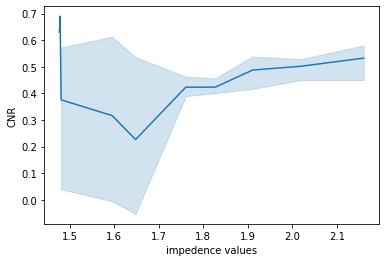

In [143]:
import seaborn as sns

#Passing the entire dataset in long-form mode will aggregate over repeated values (each year) to show the mean and 95% confidence interval


sns.lineplot(results, x='impedence values', y='CNR')

#CNR --> the higher the value, the better the image quality

<AxesSubplot:xlabel='impedence values', ylabel='FWHM'>

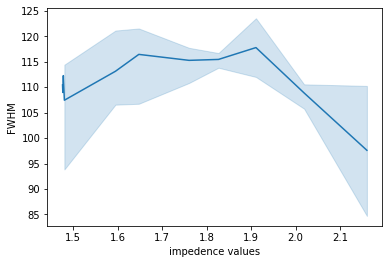

In [144]:
sns.lineplot(results, x='impedence values', y='FWHM')

#FWHM --> the lower the value, the better the image quality

Applying to All Images (USING THE TOP REGION AS ROI)

In [145]:
cnr = []
fwhm = []
impedence_values = [2.1604,2.1604,2.1604,2.0193,2.0193,2.0193,1.9111,1.9111,1.9111,1.8269,1.8269,1.8269,1.7607,1.7607,1.7607,1.6479,1.6479,1.6479,1.5954,1.5954,1.5954,1.4806,1.4806,1.4806,1.4765,1.4783,1.4771]

for image in tqdm(image_list):
    
    #calculating CNR values
    cnr_value = calculate_cnr_v2(image, 1)
    cnr.append(cnr_value)

    #calculating FWHM values
    fwhm_value = calculate_fwhm(image, 1)
    fwhm.append(fwhm_value)

100%|██████████| 27/27 [00:00<00:00, 340.04it/s]


In [146]:
#Creating Dataframe
data = {'impedence values': impedence_values,
        'CNR': cnr,
        'FWHM': fwhm}
results = pd.DataFrame(data)
results

,impedence values,CNR,FWHM
0,2.1604,0.364873,98.014785
1,2.1604,0.312135,101.727651
2,2.1604,0.380182,98.556562
3,2.0193,0.343554,97.713926
4,2.0193,0.353892,105.545196
5,2.0193,0.395316,101.942067
6,1.9111,0.356249,105.446989
7,1.9111,0.407708,107.507938
8,1.9111,0.376973,108.301452
9,1.8269,0.382311,108.114789


<AxesSubplot:xlabel='impedence values', ylabel='CNR'>

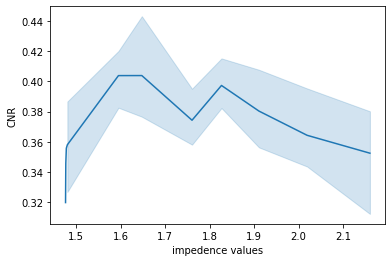

In [147]:
sns.lineplot(results, x='impedence values', y='CNR')

<AxesSubplot:xlabel='impedence values', ylabel='FWHM'>

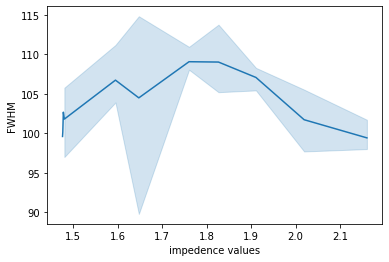

In [148]:
sns.lineplot(results, x='impedence values', y='FWHM')